In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from aerobot.io import RESULTS_PATH, load_results_dict
from aerobot.plot import plot_configure_mpl, ANNOTATION_BASED_FEATURE_TYPES, PRETTY_NAMES, plot_order_feature_types
import os
from typing import Dict, List
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plot_configure_mpl()

%load_ext autoreload
%autoreload 2

In [3]:
# Load in the results of each training run. 
nonlinear_results = dict() # Results of Nonlinear classifier. 
logistic_results = dict() # Results of LogisticRegression-based classifier. 

# Only load results for a minimal list of feature types.
for feature_type in ['KO', 'embedding.geneset.oxygen', 'embedding.genome', 'chemical', 'aa_1mer', 'aa_3mer']:
    filename = f'train_nonlinear_{feature_type}_ternary.json'
    nonlinear_results[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, filename))
    filename = f'train_logistic_{feature_type}_ternary.json'
    logistic_results[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, filename))

## Figure 1

In [4]:
def plot_figure_1a(grid:GridSpec=None, fig:plt.Figure=None):
    '''Just a placeholder, the diagram describing annotation-ful versus annotation-free pipelines for
    predicting metabolism will go here.'''
    ax = fig.add_subplot(grid)
    ax.set_axis_off()
    #ax.set_visible(False)

In [5]:
def plot_figure_1b(nonlinear_results:Dict, logistic_results:Dict, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plot comparing Nonlinear and Logistic ternary classifier performance on the holdout set.'''

    ax = fig.add_subplot(grid)
    feature_types = plot_order_feature_types(set(nonlinear_results.keys()))

    def _format_barplot_axes(ax:plt.Axes):
        random_baseline = 0.33 # Expected performance for random classifier on task. 
        # Label bins with the feature name. 
        ax.set_xticks(np.arange(0, len(feature_types), 1), [PRETTY_NAMES[f] for f in feature_types], rotation=45, ha='right')

        # Set up left y-axis with the balanced accuracy information. 
        ax.set_ylabel('balanced validation accuracy')
        ax.set_ylim(0, 1.02)
        ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1)) # xmax is the number to divide by for the percentage.

        # Add horizontal line marking model performance with random classification. 
        ax.axhline(random_baseline, color='grey', linestyle='--', linewidth=2, zorder=-10)

    # Extract the final balanced accuracies on from the results dictionaries. 
    nonlinear_val_accs  = [nonlinear_results[feature_type]['validation_acc'] for feature_type in feature_types]
    logistic_val_accs  = [logistic_results[feature_type]['validation_acc'] for feature_type in feature_types]
    
    # Map annotation-free or -full features to different colors. 
    colors = ['tab:blue' if f in ANNOTATION_BASED_FEATURE_TYPES else 'tab:green' for f in feature_types] 
    ax.bar(np.arange(0, len(feature_types), 1) - 0.2, logistic_val_accs, width=0.4, label='logistic', color=colors, edgecolor='k', linewidth=0.5, hatch='///')
    ax.bar(np.arange(0, len(feature_types), 1) + 0.2, nonlinear_val_accs, width=0.4, label='nonlinear', color=colors, edgecolor='k', linewidth=0.5)

    # Custom legend. Colors indicate annotation-free or annotation-full, and hatching indicates training or validation set. 
    handles = [plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='k', linewidth=0.5, hatch='////')]
    handles.append(plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='k', linewidth=0.5, hatch=''))
    labels = ['linear', 'nonlinear']
    plt.legend(handles, labels, ncol=2, fontsize=7, columnspacing=0.3, handletextpad=0.3, loc='upper left', bbox_to_anchor=(0.01, 0.99))

    _format_barplot_axes(ax)


/tmp/ipykernel_2329056/2293413281.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


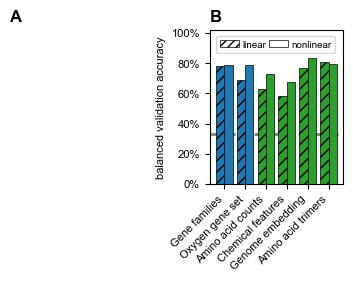

In [7]:
fig = plt.figure(figsize=(6.875, 2))
grid = GridSpec(1, 3, wspace=0.5) 

plot_figure_1a(grid=grid[0, 0], fig=fig)
# mark linear/nonlinear and annotation/annotation-free on the plot.
plot_figure_1b(nonlinear_results, logistic_results, grid=grid[0, 1], fig=fig)
# plot_figure_1c(phylo_bias_results, grid=grid[0, 2], fig=fig, show_points=False)

for panel_label, ax in zip('ABC', fig.get_axes()):
    ax.set_title(panel_label, loc='left', fontweight='bold')

plt.tight_layout()
plt.show()